In [14]:
import sys 
import os 
import pandas as pd 
pd.options.display.latex.repr = True
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.rcParams['font.sans-serif'] = ['STFangsong']
plt.rcParams['font.family']=['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.pylab as mpl
plt.rc('figure', figsize=(5, 3))
# import seaborn as sns
# sns.set_style("whitegrid")
from collections import Counter
sys.path.append('/Users/yantingting/PycharmProjects/modeling/')
import database_conncet as data_qry
import plot_tools as pt
import data_processing as dp
import plot_tools as pl

In [15]:
file_path = '/Users/yantingting/Seafile/风控/模型/13 菲律宾/线上模型复盘/新客户/'

# 1）数据提取

In [66]:
query1 = '''
select t1.order_no as order_no, t1.order_type as order_type,date(t1.created_at) as apply_day,
t2.score_v1, t2.score_v2,t2.score_old
from  
(select created_at, customer_id, order_no, order_type
 from dw_flb_approval_phl_approval_prod_approval_applications
 where product_name = 'JetPeso'
 and created_at >= '2019-10-26'
 and created_at <= '2019-12-20'
 and order_type not like 'Qua%') t1
left join 
(select order_no,
 max(case sc_id when 'phl_p2g_sc_v1' then score else null end) score_v1,
 max(case sc_id when 'phl_p2g_sc_v1_nc_gl1213' then score else null end) score_v2,
 max(case sc_id when 'phl_p2g_sc_oc_cr1218' then score else null end) score_old
 from dw_flb_approval_phl_approval_prod_score_card_results 
 GROUP BY order_no ) t2 
on t1.order_no = t2.order_no
'''

In [67]:
query2 = '''
select t1.*, t2.score_v1, t2.score_v2,t2.score_old
from  
(select * ,
case when late_day>0 then 1 else 0 end as dpd1,
case when late_day>=7 then 1 else 0 end as dpd7
from (select order_no,start_date,actual_paid_off_date,due_date,loan_days,
case when actual_paid_off_date ='1970-01-01' then '2019-12-22'- due_date else actual_paid_off_date - due_date end as late_day
from dw_flb_hx_phl_core_prod_core_repayment_schedules
where product_name='JetPeso' and extend_period= 0 and order_type not like 'Qua%'
and due_date<= '2019-12-12') a) t1
left join 
(select order_no,
 max(case sc_id when 'phl_p2g_sc_v1' then score else null end) score_v1,
 max(case sc_id when 'phl_p2g_sc_v1_nc_gl1213' then score else null end) score_v2,
 max(case sc_id when 'phl_p2g_sc_oc_cr1218' then score else null end) score_old
 from dw_flb_approval_phl_approval_prod_score_card_results 
 GROUP BY order_no) t2 
on t1.order_no = t2.order_no;
'''

In [5]:
query3 = '''
select order_no, count(1) as cnt_rej
from dw_flb_approval_phl_approval_prod_application_reasons
where in_use = 1 and reason_code in ('R101', 'R102', 'R103','R106', 'R108','R109','R201', 'R202', 'R203', 'R204','R205','R401', 'R404','R406', 'R410','R703')
group by order_no
'''

In [ ]:
命中模型情况数据提取

In [6]:
query4 = '''
select order_no,count(1) as reject_model
from dw_flb_approval_phl_approval_prod_application_reasons
where  in_use = 1 and reason_code  = 'R107'
group by order_no
'''

In [7]:
df_apply = data_qry.database_gn(query1)
df_apply.to_csv(file_path + 'df_apply.csv', index = False)
df_fund = data_qry.database_gn(query2)
df_fund.to_csv(file_path + 'df_fund.csv', index = False)
df_rule_reject = data_qry.database_gn(query3)
df_rule_reject.to_csv(file_path + 'df_rule_reject.csv', index = False)
df_model_reject = data_qry.database_gn(query4)
df_model_reject.to_csv(file_path + 'df_model_reject.csv', index = False)

Successful connection
Successful connection
Successful connection
Successful connection


# 2）v1 和 v2 在申请用户和放款用户上的表现

In [16]:
df_apply = pd.read_csv(file_path + 'df_apply.csv')
df_apply = df_apply[~df_apply['score_v2'].isnull()]
df_fund = pd.read_csv(file_path + 'df_fund.csv')
df_fund = df_fund[~df_fund['score_v2'].isnull()]
df_apply.shape
df_fund.shape
use_cols = ['order_no', 'start_date', 'actual_paid_off_date', 'due_date',
       'loan_days', 'late_day', 'dpd1', 'dpd7']
my_df = pd.merge(df_apply, df_fund[use_cols], on = 'order_no', how='left')
# my_df.info()

(42526, 6)

(4246, 11)

In [17]:
new_v1_score_bin = sorted(set(my_df['score_v1'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9]).values))
new_v1_score_bin.insert(0, 0)
new_v1_score_bin.append(1000)
new_v2_score_bin = sorted(set(my_df['score_v2'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9]).values))
new_v2_score_bin.insert(0, 0)
new_v2_score_bin.append(1000)
new_v1_score_bin
new_v2_score_bin

[0, 344.0, 404.0, 446.0, 485.0, 525.0, 567.0, 611.0, 664.0, 731.0, 1000]

[0, 528.0, 551.0, 568.0, 585.0, 600.0, 616.0, 633.0, 652.0, 680.0, 1000]

In [20]:
my_df['group_v1'] = pd.cut(my_df['score_v1'], new_v1_score_bin, right=True)
my_df['group_v2'] = pd.cut(my_df['score_v2'], new_v2_score_bin, right=True)
my_df.to_csv(file_path + 'my_df.csv')
my_group1 = my_df.groupby(['group_v1'])
frame1 = pd.DataFrame()
frame1['cnt_apply'] = my_group1['order_no'].agg('count')
frame1['cnt_fund'] = my_group1['start_date'].agg('count')
frame1['cnt_fdq'] = my_group1['dpd1'].agg('sum')
frame1['cnt_dpd7+'] = my_group1['dpd7'].agg('sum')
frame1['FDQ'] = frame1['cnt_fdq']/frame1['cnt_fund']
frame1['DPD7+'] = frame1['cnt_dpd7+']/frame1['cnt_fund']
frame1 = frame1.reset_index()
frame1

my_group2 = my_df.groupby(['group_v2'])
frame2 = pd.DataFrame()
frame2['cnt_apply'] = my_group2['order_no'].agg('count')
frame2['cnt_fund'] = my_group2['start_date'].agg('count')
frame2['cnt_fdq'] = my_group2['dpd1'].agg('sum')
frame2['cnt_dpd7+'] = my_group2['dpd7'].agg('sum')
frame2['FDQ'] = frame2['cnt_fdq']/frame2['cnt_fund']
frame2['DPD7+'] = frame2['cnt_dpd7+']/frame2['cnt_fund']
frame2 = frame2.reset_index()
frame2

,group_v1,cnt_apply,cnt_fund,cnt_fdq,cnt_dpd7+,FDQ,DPD7+
0,"(0.0, 344.0]",4277,77,55.0,38.0,0.714286,0.493506
1,"(344.0, 404.0]",4258,166,105.0,74.0,0.632530,0.445783
2,"(404.0, 446.0]",4280,221,137.0,97.0,0.619910,0.438914
3,"(446.0, 485.0]",4276,274,186.0,137.0,0.678832,0.500000
4,"(485.0, 525.0]",4238,289,186.0,131.0,0.643599,0.453287
5,"(525.0, 567.0]",4232,406,243.0,156.0,0.598522,0.384236
6,"(567.0, 611.0]",4260,527,310.0,198.0,0.588235,0.375712
7,"(611.0, 664.0]",4236,572,324.0,195.0,0.566434,0.340909
8,"(664.0, 731.0]",4267,678,363.0,219.0,0.535398,0.323009
9,"(731.0, 1000.0]",4202,1024,515.0,270.0,0.502930,0.263672


,group_v2,cnt_apply,cnt_fund,cnt_fdq,cnt_dpd7+,FDQ,DPD7+
0,"(0.0, 528.0]",4308,0,0.0,0.0,NaN,NaN
1,"(528.0, 551.0]",4406,0,0.0,0.0,NaN,NaN
2,"(551.0, 568.0]",4102,0,0.0,0.0,NaN,NaN
3,"(568.0, 585.0]",4422,0,0.0,0.0,NaN,NaN
4,"(585.0, 600.0]",4130,289,208.0,154.0,0.719723,0.532872
5,"(600.0, 616.0]",4346,416,280.0,206.0,0.673077,0.495192
6,"(616.0, 633.0]",4254,461,274.0,179.0,0.594360,0.388286
7,"(633.0, 652.0]",4135,494,282.0,179.0,0.570850,0.362348
8,"(652.0, 680.0]",4221,1211,689.0,428.0,0.568951,0.353427
9,"(680.0, 1000.0]",4202,1363,691.0,369.0,0.506970,0.270726


Text(0.5, 1.0, 'score_v1 in 10 Quantiles')

Text(0.5, 1.0, 'score_v2 in 10 Quantiles')

<Figure size 360x216 with 0 Axes>

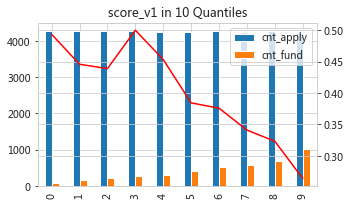

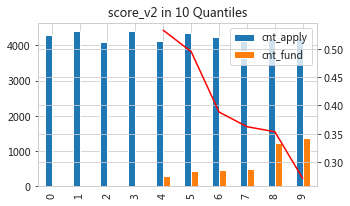

Text(0.5, 0, 'quantile')

Text(0, 0.5, 'overdue')

Text(0.5, 1.0, 'score_v1 VS score_v2 申请和放款用户')

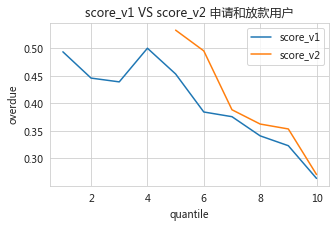

In [19]:
# 1)分开绘图
fig = plt.figure()
# ax1 = fig.add_subplot(121)
ax1 = frame1[['cnt_apply', 'cnt_fund']].plot.bar()
plt.legend(loc= 'upper right')
ax2 = ax1.twinx()   #组合图必须加这个
ax2.plot(frame1['DPD7+'] ,color = 'r')
plt.title('score_v1 in 10 Quantiles')
# ax3 = fig.add_subplot(122)
ax3 = frame2[['cnt_apply', 'cnt_fund']].plot.bar()
plt.legend(loc= 'upper right')
ax4 = ax3.twinx()   #组合图必须加这个
ax4.plot(frame2['DPD7+'] ,color = 'r')
plt.title('score_v2 in 10 Quantiles')
plt.savefig(file_path + 'figure/fig1.png', format='png', dpi=80)
plt.show()
plt.close()

# 2）一张图
x = range(1,11)
plt.plot(x,frame1['DPD7+'] )
plt.plot(x,frame2['DPD7+'] )
plt.xlabel('quantile')
plt.ylabel('overdue')
plt.title('score_v1 VS score_v2 申请和放款用户')
plt.legend(['score_v1', 'score_v2'],loc = 'upper right')
plt.savefig(file_path + 'figure/fig2.png', format='png', dpi=80)
plt.show()
plt.close()

score_v1 is in processing


,group,total,bad,good,per%,overdue,cum_bad,cum_good,KS,cum_overdue,WOE,IV
0,score_v1,total,bad,good,per%,overdue,cum_bad,cum_good,KS,cum_overdue,WOE,IV
1,"(204.999, 439.0]",428,197,231,0.100801,0.46028,0.12952,0.0847706,0.0447494,0.46028,0.423886,0.0189687
2,"(439.0, 500.0]",422,206,216,0.0993877,0.488152,0.264957,0.164037,0.100921,0.474118,0.535698,0.0300908
3,"(500.0, 551.0]",429,171,258,0.101036,0.398601,0.377383,0.258716,0.118668,0.448788,0.171804,0.00304904
4,"(551.0, 589.0]",420,168,252,0.0989166,0.4,0.487837,0.351193,0.136644,0.436727,0.177635,0.00319328
5,"(589.0, 628.0]",425,143,282,0.100094,0.336471,0.581854,0.454679,0.127175,0.416667,-0.095962,0.000908678
6,"(628.0, 665.0]",426,150,276,0.10033,0.352113,0.680473,0.555963,0.12451,0.405882,-0.0266652,7.10646e-05
7,"(665.0, 706.0]",428,150,278,0.100801,0.350467,0.779093,0.657982,0.121111,0.397918,-0.0338854,0.000115177
8,"(706.0, 746.0]",422,115,307,0.0993877,0.272512,0.854701,0.770642,0.0840587,0.382353,-0.398815,0.0147771
9,"(746.0, 798.0]",424,113,311,0.0998587,0.266509,0.928994,0.884771,0.0442234,0.369508,-0.429305,0.0171014


KS =  0.13664428882495216
IV =  0.10968646963335896
score_v2 is in processing


,group,total,bad,good,per%,overdue,cum_bad,cum_good,KS,cum_overdue,WOE,IV
0,score_v2,total,bad,good,per%,overdue,cum_bad,cum_good,KS,cum_overdue,WOE,IV
1,"(588.999, 606.0]",441,231,210,0.103862,0.52381,0.151874,0.0770642,0.0748095,0.52381,0.678411,0.0507516
2,"(606.0, 622.0]",412,184,228,0.0970325,0.446602,0.272847,0.160734,0.112113,0.486518,0.368691,0.0137534
3,"(622.0, 638.0]",439,178,261,0.103391,0.405467,0.389875,0.256514,0.133361,0.458978,0.200364,0.00425742
4,"(638.0, 653.0]",408,140,268,0.0960904,0.343137,0.48192,0.354862,0.127057,0.431176,-0.0662441,0.000417598
5,"(653.0, 663.0]",463,171,292,0.109044,0.36933,0.594346,0.462018,0.132327,0.417938,0.0480102,0.000253017
6,"(663.0, 672.0]",407,155,252,0.0958549,0.380835,0.696252,0.554495,0.141757,0.412062,0.0970964,0.000915578
7,"(672.0, 683.0]",433,128,305,0.101978,0.295612,0.780408,0.666422,0.113986,0.395271,-0.285181,0.00791989
8,"(683.0, 696.0]",416,150,266,0.0979746,0.360577,0.879027,0.764037,0.11499,0.39105,0.0102394,1.0287e-05
9,"(696.0, 715.0]",409,102,307,0.096326,0.249389,0.946088,0.876697,0.0693909,0.375914,-0.518775,0.0236558


KS =  0.14175705263919802
IV =  0.15934102949015871


Text(0.5, 1.0, 'v1 VS v2 in 10 quantile')

Text(0.5, 0, 'quantile')

Text(0, 0.5, 'overdue')

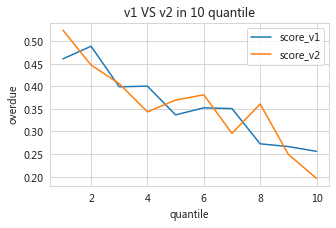

In [21]:
var_list = ['score_v1','score_v2']
for col in var_list:
    print('{} is in processing'.format(col))
    temp_frame = dp.ContinuousBin(df_fund, col , target = 'dpd7', n = 10, special_attribute = [],method = 'equal freq')[0]
    ks = dp.ContinuousBin(df_fund, col , target = 'dpd7', n = 10, special_attribute = [],method = 'equal freq')[1]
    iv = dp.ContinuousBin(df_fund, col , target = 'dpd7', n = 10, special_attribute = [],method = 'equal freq')[2]
    temp_frame
    plt.plot(range(1,11),temp_frame[1:]['overdue'] )
    print('KS = ', ks)
    print('IV = ', iv)
    
plt.title('v1 VS v2 in 10 quantile')
plt.xlabel('quantile')
plt.ylabel('overdue')
plt.legend(['score_v1', 'score_v2'], loc = 0, ncol = 1) 
plt.savefig(file_path + 'fig2.png', format='png', dpi=80)
plt.show()
plt.close()

# 匹配规则

In [104]:
df_rule_reject = pd.read_csv(file_path + 'df_rule_reject.csv')
df_model_reject = pd.read_csv(file_path + 'df_model_reject.csv')
my_df = pd.read_csv(file_path + 'my_df.csv')
df_result = pd.merge(my_df,df_rule_reject, on='order_no',how='left')
df_result = pd.merge(df_result,df_model_reject, on='order_no',how='left')
df_result['reject_rule'] = df_result['cnt_rej'].apply(lambda x: 1 if x>0 else 0)
df_result.to_excel(file_path + 'df_reault.xlsx')